In [11]:
import os 
import sys
import argparse
import numpy as np 
import pandas as pd 

# Statistical methods
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

src_dir = os.path.normpath(os.path.join(os.getcwd(), "src/util"))
sys.path.insert(0, src_dir)
src_dir_data = os.path.normpath(os.path.join(os.getcwd(), "Analysis_model"))
sys.path.insert(0, src_dir_data)

import util
import FileIO as fio 
import PCA_Analysis as pca 
import warnings
warnings.filterwarnings("ignore")

# Statistical functions 

In [6]:
def reformat_results(results, col):
    """
    Takes dataframe results with columns 'col' and 'effect'
    Return +/- values in 'col', signed according to effect
    """
    results[col] = results[col].replace(0, 1e-20)
    return results[col]*np.sign(results['effect'])

def sign_results(results, df, dis_smpls, H_smpls, dataset, col):
    """
    Convert one results dataframe with p-values for all OTUs in df 
    into two dataframe with 'effect' columms calculated using median and mean
    """
    results['effect'] = df.loc[dis_smpls].median() - df.loc[H_smpls].mean()
    med_results = reformat_results(results, col)
    med_results.name = dataset
    
    results['effect'] = df.loc[dis_smpls].mean() - df.loc[H_smpls].mean()
    mean_results = reformat_results(results, col)
    mean_results.name = dataset
    
    return med_results, mean_results

def compare_OTU_stattest(df, D_smpls, H_smpls, method='kruskal-wallis', multi_comp=None):
    """
    Compares columns between D_smpls and H_smpls with statistical tests 
    Return df with both the qvals and statistical tests
    """
    if method == 'kruskal-wallis':
        pfun = stats.kruskal
    elif method == 'wilcoxon' or method == 'ranksums':
        pfun = stats.ranksums
    elif method == 'mann-whitney':
        pfun = stats.mannwhitneyu
        
    results = pd.DataFrame(index=df.columns, columns = ['test_stat', 'p'])
    for o in df.columns:
        try:
            h, p = pfun(df.loc[D_smpls, o], df.loc[H_smpls, o])
        except:
            p = 1
            h = 0
        results.loc[o, 'p'] = p
        results.loc[o, 'test-stat'] = h
    
    if multi_comp == 'fdr':
        _, results['q'], _, _= multipletests(results['p'], method = 'fdr_bh')
        
    return results


# Statistical analysis

In [4]:
dfdict = fio.read_dfdict_data("data/clean_tables")

Reading datasets...
ob_turnbaugh
asd_son
hiv_dinh
crc_zeller
ob_ross
crc_wang
hiv_lozupone
t1d_alkanani
par_scheperjans
cdi_vincent
ob_zupancic
noncdi_schubert
t1d_mejialeon
ob_zhu
liv_zhang
hiv_noguerajulian
cdi_schubert
ob_goodrich
edd_singh
cdi_youngster
ibd_willing
art_scher
crc_chen
ibd_papa
nash_wong
ibd_morgan
crc_baxter
ibd_gevers
nash_zhu
asd_kang

Reading datasets... Finished.


### Loss of beneficial microbes or enrichment of pathogens
#### Targets 
- Whether the specific type of alteration was consistent across independent cohorts of patents with the same disease 
- In some diseases, microbiome shifts are dominated by an enrichment of a small number of "pathogenic" bacteria. It is posible that the microbes play a causal role and that they could be targeted with narrow-spectrum anti-microbials.
- By contrast, other disease-associated microbiome shifts are characterized by a depletion of health-associated bacteria in patients relative to controls. Probiotics that replaces missing taxa may be a better treatment strategy than anti-microbials

#### Methods 
- Perform univariate tests ([Kruskal-Walli test](https://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance) with [Benjamini–Hochberg false discovery rate - FDR](https://en.wikipedia.org/wiki/False_discovery_rate)) on genus-levels relative abundances for each data set independently and compare results across studies

In [7]:
resultsdict = {}
for dataset in dfdict:
    df = dfdict[dataset]["df"]
    meta = dfdict[dataset]["meta"]
    
    df = util.collapse_taxonomic_contents_df(df, "genus")
    
    classes_list = fio.get_classes(meta, dataset)
    H_smpls, dis_smpls = fio.get_samples(meta, classes_list)
    
    # Statistical methods: kruskal-wallis, wilcoxon, ranksums and mann-whitney 
    results = compare_OTU_stattest(df, dis_smpls, H_smpls, method = 'kruskal-wallis', multi_comp = "fdr")
    resultsdict[dataset] = {
        "df": df, "meta": meta,
        "dis_smpls": dis_smpls, "H_smpls": H_smpls,
        "results": results
    }

In [12]:
med_allresults_lst = []
mean_allresults_lst = []
for dataset in resultsdict:
    results = resultsdict[dataset]["results"]
    df = resultsdict[dataset]["df"]
    dis_smpls = resultsdict[dataset]["dis_smpls"]
    H_smpls = resultsdict[dataset]["H_smpls"]
    med_results, mean_results = sign_results(results, df, dis_smpls, H_smpls, dataset, col="q")
    med_allresults_lst.append(med_results)
    mean_allresults_lst.append(mean_results)

med_allresults = pd.concat(med_allresults_lst, axis=1)
mean_allresults = pd.concat(mean_allresults_lst, axis=1)

# Visualization 

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
def plot_disease_heatmap(disdf, samplesizes, vmax=None, with_labels=True):
    if 'dataset' in samplesizes.columns:
        samplesizes.index = samplesizes['dataset']
    
    fig = plt.figure(figsize=(10, 0.15*disdf.shape[0]))

    ax_heatmap = plt.gca()
    
    if vmax is None:
        vmax = max(disdf.max().max(), -disdf.min().min())
    
    cax = ax_heatmap.imshow(disdf.values, interpolation="nearest", aspect="auto",
                           cmap=sns.diverging_palette(220, 20, as_cmap=True),
                           vmax=vmax, vmin=-vmax)
    ax_heatmap.set_aspect(0.1)
    cbar = ax_heatmap.figure.colorbar(cax, ax=ax_heatmap)
    
    if with_labels:
        labels = []
        for dataset in disdf:
            label = dataset.split('_')[1]
            if dataset == 'cdi_schubert2':
                label = 'Schubert\n(nonCDI)'
            elif dataset == 'cdi_schubert':
                label = 'Schubert\n(CDI)'
            elif dataset in ['edd_singh', 'cdi_singh']:
                label = 'Singh\n(EDD)'
            elif dataset in ['cdi_vincent', 'cdi_youngster']:
                label += '\n(CDI)'
            label += '\n' + str(samplesizes.loc[dataset, 'N_ctrl'])\
                  + '\n' + str(samplesizes.loc[dataset, 'N_dis'])
            labels.append(label)
        ax_heatmap.set_xticks(range(disdf.shape[1]))
        ax_heatmap.set_xticklabels(labels, fontsize='large')
        ax_heatmap.set_yticks(range(disdf.shape[0]))
        ax_heatmap.set_yticklabels([''.join(i.split(";")[-1][3:]) for i in disdf.index], 
                                   fontsize='medium')
    else: 
        ax_heatmap.set_yticks([])
        ax_heatmap.set_yticklabels([])
        ax_heatmap.set_xticks(range(0, disdf.shape[1]))
        ax_heatmap.set_xticklabels('')
    
    return fig 

In [17]:
dataset_info = pd.read_csv("data/analysis_results/datasets_info.txt", sep='\t')

In [18]:
dfpvals = mean_allresults.rename(columns = {'edd_singh': 'cdi_singh',
                                            'noncdi_schubert': 'cdi_schubert2'})
dfpvals.index.name = 'otu'
dataset_info = dataset_info\
    .replace('edd_singh', 'cdi_singh')\
    .replace('noncdi_schubert', 'cdi_schubert2')
dataset_info = dataset_info.sort_values(by='total', ascending=False)

In [20]:
sigmap = lambda x: np.sign(x) if abs(x) < 0.05 else 0
dfsig = dfpvals.applymap(sigmap)
datasets = dfsig.columns

### Clostridium difficile infection (CDI)

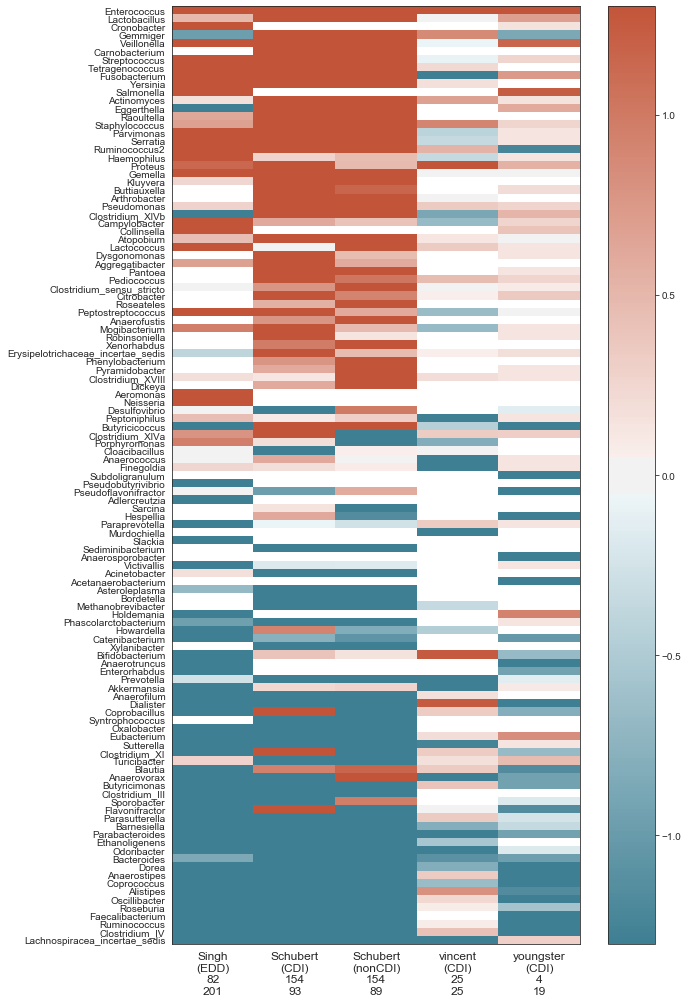

In [38]:
cdi_disease = 'cdi' + '_'
keep_cdi = [i for i in datasets if i.startswith(cdi_disease)]
cdi_df = dfsig[keep_cdi]
cdi_df = dfpvals.loc[cdi_df.apply(abs).sum(axis=1) != 0, keep_cdi]
cdi_df = cdi_df.applymap(lambda x: np.sign(x) * abs(np.log10(abs(x))))
cdi_df = cdi_df.loc[cdi_df.sum(axis=1).sort_values(ascending=False).index]
cdi_df = cdi_df[[i for i in dataset_info['dataset'] if i in keep_cdi]]
fig = plot_disease_heatmap(cdi_df, dataset_info, vmax=abs(np.log10(0.05)), with_labels=True)

- Rows include all genera which are significant in at least one data set within each disease, columns are data set with Healthy samples (above) and Disease samples (under).
- q values are colored by direction of the effect, red indicates higher mean abundance in disease patients and blue indicates higher mean abundance in controls (healthy).
- White indicates that genus was not present in that data set.
- Rows are ordered from most disease-associated (top) and most health-associated (bottom)

### Colorectal cancer (CRC)

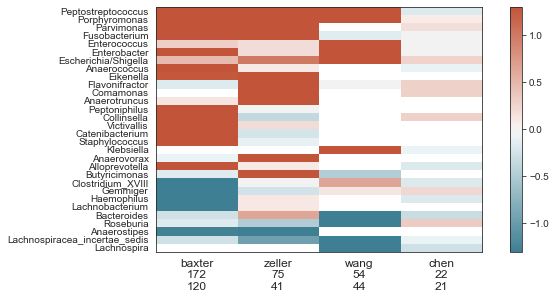

In [39]:
crc = 'crc' + '_'
keep_crc = [i for i in datasets if i.startswith(crc)] 
crcdf = dfsig[keep_crc]
crcdf = dfpvals.loc[crcdf.apply(abs).sum(axis=1) != 0, keep_crc]
crcdf = crcdf.applymap(lambda x: np.sign(x)*abs(np.log10(abs(x))))
crcdf = crcdf.loc[crcdf.sum(axis=1).sort_values(ascending=False).index]
crcdf = crcdf[[i for i in dataset_info['dataset'] if i in keep_crc]]
fig = plot_disease_heatmap(crcdf, dataset_info, vmax=abs(np.log10(0.05)), 
                           with_labels=True)

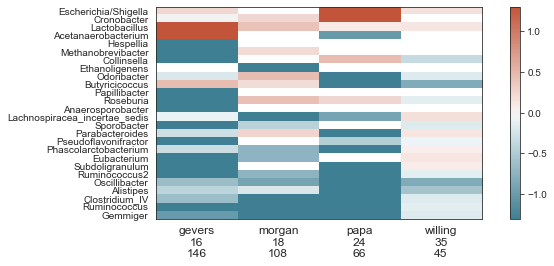

In [41]:
ibd = 'ibd' + '_'
keep_ibd = [i for i in datasets if i.startswith(ibd)] 
ibddf = dfsig[keep_ibd]
ibddf = dfpvals.loc[ibddf.apply(abs).sum(axis=1) != 0, keep_ibd]
ibddf = ibddf.applymap(lambda x: np.sign(x)*abs(np.log10(abs(x))))
ibddf = ibddf.loc[ibddf.sum(axis=1).sort_values(ascending=False).index]
ibddf = ibddf[[i for i in dataset_info['dataset'] if i in keep_ibd]]
fig = plot_disease_heatmap(ibddf, dataset_info, vmax=abs(np.log10(0.05)), 
                           with_labels=True)